# [CompuCell3D](http://compucell3d.org) in a Jupyter Notebook

> CompuCell3D is an open-source simulation environment for multi-cell, single-cell-based modeling of tissues, organs and organisms.

>It uses Cellular Potts Model to model cell behavior.

>This project is funded by the NIH and EPA.

>Compucell3D is led by Maciej Swat (IU), James Glazier(IU) and Roshan D'Souza (U.Wisc. Milwaukee) 

## Structure of the Simulations directory tree

* DATA_ROOT
    - ...
    - Sim2_cc3d_dd_MM_yyyy_hh_mm_ss
        * LatticeData
            - vtk_files ... **Here are the data**
        * Simulation
            - xml & python files ...
    
    
    - ...
    


### Parsing xml and python files

This is used for parameters management

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os



from IPython.display import Markdown, display

import matplotlib.pyplot as plt
from scipy.stats import linregress

from cc3d_parser import *
from plot_routines import *
import seaborn as sns

%matplotlib inline

/home/guillaume/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [10]:

DATA_ROOT_base = '/home/guillaume/CC3DWorkspace/Sim2_ParameterScan_'
suffixes = ['{}_Ps{}'.format(a, b) for a in ['none', 'before', 'after']
#            for b in ['0.5', '0.6', '0.7', '0.8']]
            for b in ['0.7',]]


In [4]:
i = 0

In [5]:
collected_tumors = {}

for suffix in suffixes:

    DATA_ROOT = DATA_ROOT_base + suffix
    sim_name = suffix
    print("Treating  {}".format(sim_name))
    collected_tumors[suffix] = parse_data_dir(DATA_ROOT)
    
    
    # collect_tumor_data(tumors, collected)



Treating  none_Ps0.7
Treating  before_Ps0.7
Treating  after_Ps0.7


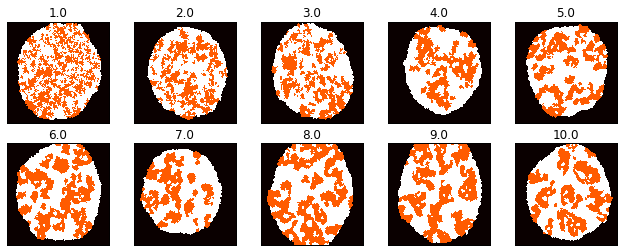

/home/guillaume/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:1718: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


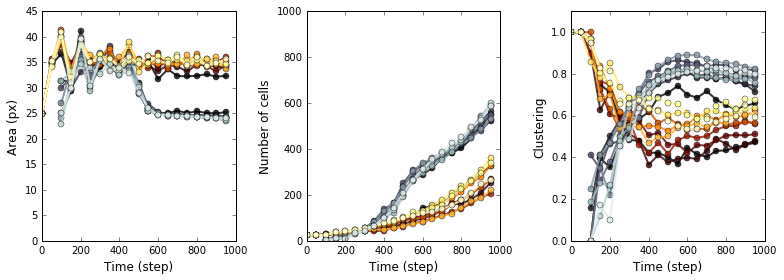

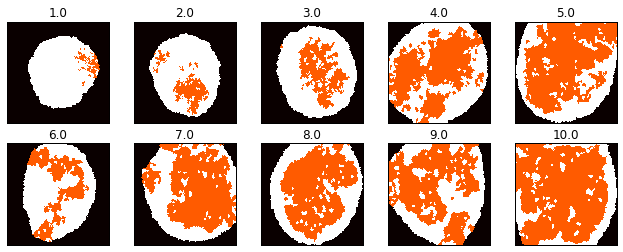

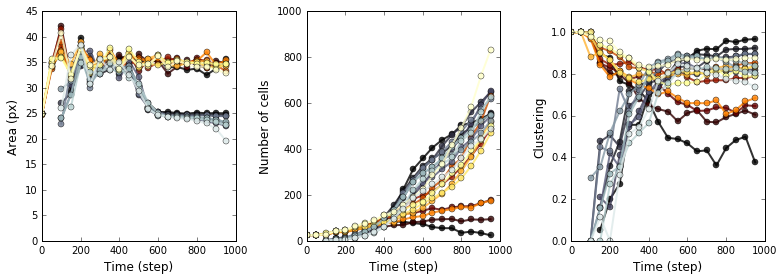

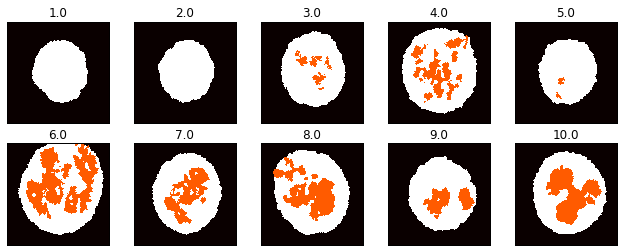

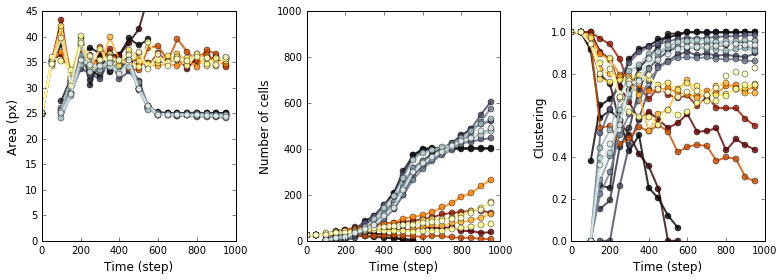

In [6]:

for suffix in suffixes:

    tumors = collected_tumors[suffix]
    frame_num = -1
    dpi = 90

    pix_width = 1024
    pix_height = 400

    f_size_i = (pix_width/dpi, pix_height/dpi)

    fig, axes = show_type(tumors, frame_num, f_size_i)

    plt.savefig('types_{}.svg'.format(sim_name))

    show_time_components(tumors, f_size_i)
    plt.savefig('evolution_{}.svg'.format(sim_name))


In [4]:
collected_data = collect_tumor_data(tumors, collected_tumors, suffixes)

# with pd.get_store('collected.h5') as store:
#         collected_data = store['data']

NameError: name 'tumors' is not defined

In [8]:

def save_collected(collected_data, storename='collected.h5'):
    root = os.path.dirname(DATA_ROOT_base)
    with pd.get_store(os.path.join(root, storename)) as store:
        store['data'] = collected_data

def load_collected(storename='collected.h5'):
    root = os.path.dirname(DATA_ROOT_base)
    with pd.get_store(os.path.join(root, storename)) as store:
        collected_data = store['data']
    return collected_data

In [31]:
save_collected(collected_data)

In [13]:
collected_data = load_collected('collected.h5')
collected_data['colors'] = [(0,)*4 for 
                            i in range(collected_data.shape[0])]
collected_data.reset_index(inplace=True, drop=True)

In [14]:
collected_data.head()

,area_frac,clustering_csc,clustering_npc,csc_frac,diff_adh,pop_csc,sim_name,colors
0,1.429380,0.432963,0.952678,0.041594,1,24,before_Ps0.7,"(0, 0, 0, 0)"
1,1.413191,0.599731,0.913121,0.144838,2,94,before_Ps0.7,"(0, 0, 0, 0)"
2,1.410663,0.637390,0.886313,0.215496,3,178,before_Ps0.7,"(0, 0, 0, 0)"
3,1.497414,0.778101,0.818807,0.428070,4,488,before_Ps0.7,"(0, 0, 0, 0)"
4,1.471401,0.839543,0.810206,0.537808,5,633,before_Ps0.7,"(0, 0, 0, 0)"


In [15]:
sim_map.to_rgba(i)

NameError: name 'sim_map' is not defined

In [81]:
sim_names

array(['before_Ps0.7', 'after_Ps0.7', 'none_Ps0.7'], dtype=object)

In [91]:
idx

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
            2, 3, 4, 5, 6, 7, 8, 9],
           dtype='int64')

In [94]:
collected_data.loc[idx, 'colors']

0     (0, 0, 0, 0)
1     (0, 0, 0, 0)
2     (0, 0, 0, 0)
3     (0, 0, 0, 0)
4     (0, 0, 0, 0)
5     (0, 0, 0, 0)
6     (0, 0, 0, 0)
7     (0, 0, 0, 0)
8     (0, 0, 0, 0)
9     (0, 0, 0, 0)
10    (0, 0, 0, 0)
11    (0, 0, 0, 0)
12    (0, 0, 0, 0)
13    (0, 0, 0, 0)
14    (0, 0, 0, 0)
15    (0, 0, 0, 0)
16    (0, 0, 0, 0)
17    (0, 0, 0, 0)
18    (0, 0, 0, 0)
19    (0, 0, 0, 0)
20    (0, 0, 0, 0)
21    (0, 0, 0, 0)
22    (0, 0, 0, 0)
23    (0, 0, 0, 0)
24    (0, 0, 0, 0)
25    (0, 0, 0, 0)
26    (0, 0, 0, 0)
27    (0, 0, 0, 0)
28    (0, 0, 0, 0)
29    (0, 0, 0, 0)
Name: colors, dtype: object

In [101]:
collected_data[collected_data['sim_name'] == name].index

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')

In [97]:
collected_data.shape

(30, 9)

In [102]:
%pdb

Automatic pdb calling has been turned ON


In [23]:
idx = collected_data.where(collected_data['sim_name'] == name)

In [24]:
len(idx)

30

In [25]:
len(color)

40

In [27]:
idx = collected_data.where(collected_data['sim_name'] == name)

color = np.array(tuple(sim_map.to_rgba(i),)*len(idx))
collected_data.loc[idx, 'colors'] = color

ValueError: cannot copy sequence with size 8 to array axis with dimension 30

In [16]:

sim_names = collected_data.sim_name.unique()
sim_norm  = colors.Normalize(vmin=0, vmax=len(sim_names))
sim_map = plt.cm.ScalarMappable(norm=sim_norm, cmap=sim_cm)

for n, name in enumerate(sim_names):
    color = sim_map.to_rgba(n)
    collected_data[collected_data['sim_name']==name]['colors'] = sim_map.to_rgba(i)


ValueError: Length of values does not match length of index

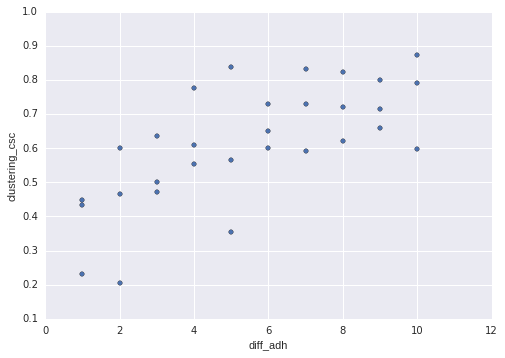

In [43]:
collected_data.plot.scatter('diff_adh', 'clustering_csc', colors=)

/home/guillaume/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


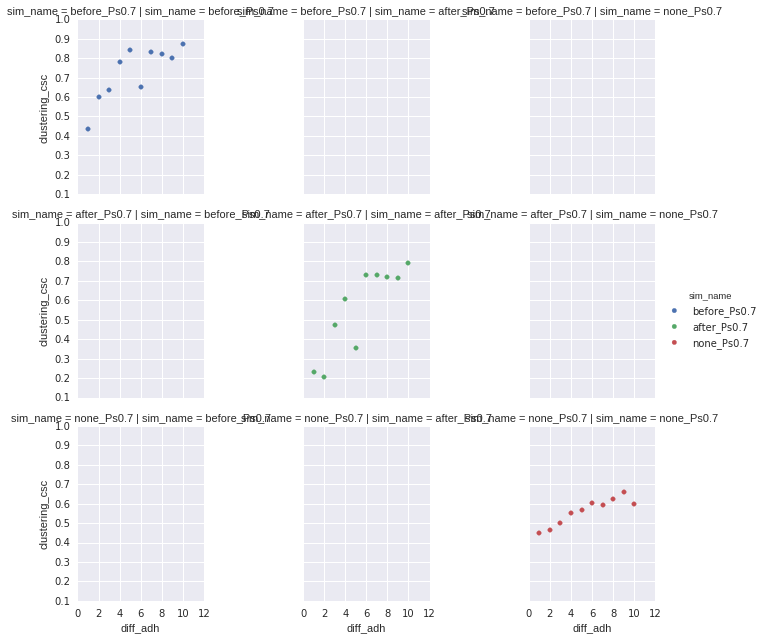

In [38]:
g = sns.FacetGrid(collected_data, row="sim_name", col="sim_name", hue="sim_name")
g.map(plt.scatter, "diff_adh", "clustering_csc")
g.add_legend()



!curl https://raw.github.com/pydata/pandas/master/pandas/tests/data/tips.csv
!cat tips.csv

In [12]:
tips_data

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
5,25.29,4.71,Male,No,Sun,Dinner,4
6,8.77,2.00,Male,No,Sun,Dinner,2
7,26.88,3.12,Male,No,Sun,Dinner,4
8,15.04,1.96,Male,No,Sun,Dinner,2
9,14.78,3.23,Male,No,Sun,Dinner,2


In [10]:
pix_width = 600
pix_height = 1024

f_size_i = (pix_width/dpi, pix_height/dpi)

columns = [
    'area_frac',
    'clustering_csc',
    'clustering_npc',
    'csc_frac',
    'pop_csc']

ylabels = {
    'area_frac': 'CSC to NPC area ratio',
    'clustering_csc': 'CSC clustering',
    'clustering_npc': 'NPC clustering',
    'csc_frac': 'Fraction of CSC cells',
    'pop_csc': 'CSC final population'
    }

ylims = {
    'area_frac': (0, 1.1),
    'clustering_csc': (0, 1.1),
    'clustering_npc': (0, 1.1),
    'csc_frac': (0, 1.1),
    'pop_csc': (0, 1.1)
    }


colors = {
    'before_Ps0.7':'#3139ae',
    'after_Ps0.7':'#bc2122',
    'none_Ps0.7': '#3a7c0e'
    }

g = sns.FacetGrid(tips_data, row="sex", col="smoker", margin_titles=True)
g.map(sns.regplot, "total_bill", "tip", order=2)

fig, axes = plt.subplots(5, 1, sharex=True)
fig.set_size_inches(f_size_i)
for col, ax in zip(columns, axes):
    for key, df in collected_data.items():
        ax.plot(df.index, df[col], color=colors[key], lw=2, alpha=0.8)
    ax.set_ylabel(ylabels[col])
axes[-1].set_xlabel('Differential adhesion energy')
fig.set_tight_layout(True)

NameError: name 'dpi' is not defined

In [15]:
from skimage import io

In [16]:
ls ../../InVivo_data/Data_neuroblasr/


im1_cells.tif  im1_types.tif  im2_data.csv   im3_cells.tif  im3_types.tif
im1_data.csv   im2_cells.tif  im2_types.tif  im3_data.csv


In [17]:
in_vivo_path = '../../InVivo_data/Data_neuroblasr/'
segmented = io.imread(os.path.join(in_vivo_path, 'im1_cells.tif'))
types = io.imread(os.path.join(in_vivo_path, 'im1_types.tif'))
data = pd.read_csv(os.path.join(in_vivo_path, 'im1_data.csv'), sep='\t')

In [50]:
data.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            214, 215, 216, 217, 218, 219, 220, 221, 222, 223],
           dtype='int64', length=224)

In [54]:
labels = (segmented[:, :, 0]).copy().astype(np.int)

for ix, cell in data.iterrows():
    x, y = int(cell.center_x_cells), int(cell.center_y_cells)
    color = segmented[y, x]
    labels[np.product(segmented == color, axis=2)] = ix
labels = morphology.erosion(labels, morphology.square(3))    

In [55]:
rag = graph.rag_mean_color(segmented, labels)

In [56]:
rag.edges()

[(0, 64),
 (0, 187),
 (0, 53),
 (2, 112),
 (2, 81),
 (2, 180),
 (2, 86),
 (2, 212),
 (2, 252),
 (2, 191),
 (3, 192),
 (3, 64),
 (3, 198),
 (3, 135),
 (3, 40),
 (3, 170),
 (3, 203),
 (3, 14),
 (3, 16),
 (3, 18),
 (3, 118),
 (3, 55),
 (3, 152),
 (3, 58),
 (8, 129),
 (8, 86),
 (8, 139),
 (8, 148),
 (8, 26),
 (8, 27),
 (8, 157),
 (8, 44),
 (8, 45),
 (8, 176),
 (8, 50),
 (8, 184),
 (8, 61),
 (8, 64),
 (8, 66),
 (8, 214),
 (8, 220),
 (8, 96),
 (8, 226),
 (8, 105),
 (8, 119),
 (8, 252),
 (9, 40),
 (9, 105),
 (9, 226),
 (9, 86),
 (9, 49),
 (13, 225),
 (13, 17),
 (13, 33),
 (13, 70),
 (13, 113),
 (13, 139),
 (13, 44),
 (13, 81),
 (13, 179),
 (13, 22),
 (13, 185),
 (13, 132),
 (13, 36),
 (13, 223),
 (14, 64),
 (14, 37),
 (14, 200),
 (14, 170),
 (14, 140),
 (14, 205),
 (14, 104),
 (14, 86),
 (14, 250),
 (14, 150),
 (14, 133),
 (16, 197),
 (16, 203),
 (16, 53),
 (16, 55),
 (16, 152),
 (17, 67),
 (17, 197),
 (17, 230),
 (17, 139),
 (17, 140),
 (17, 203),
 (17, 22),
 (17, 250),
 (17, 126),
 (18, 49)

In [51]:
from skimage import morphology

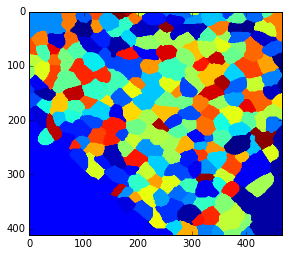

In [58]:
fig, ax = plt.subplots()
ax.imshow(labels)

In [18]:
from scipy.spatial import Delaunay

In [21]:
points = data[['center_x_cells', 'center_y_cells']]
delaunay = Delaunay(points)

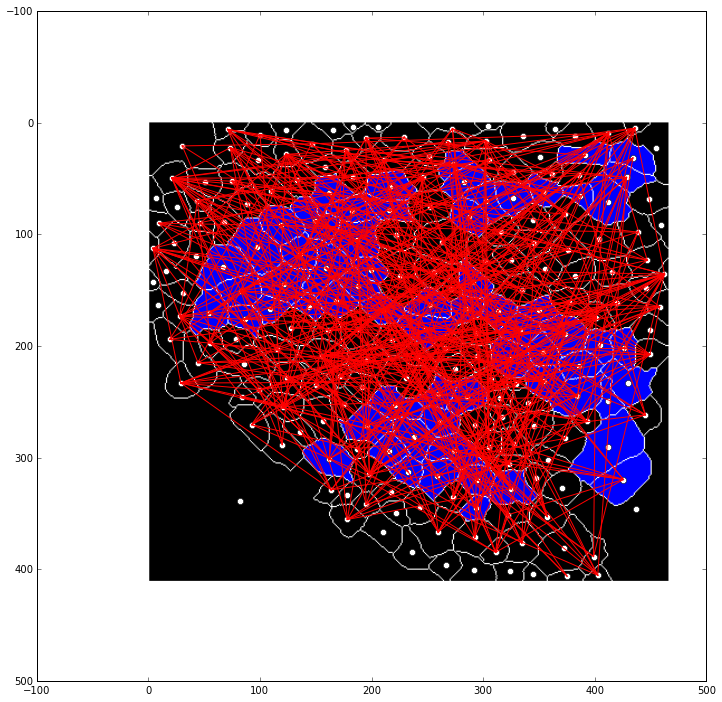

In [57]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(types)
ax.plot(data.center_x_cells, 
        data.center_y_cells, 'wo')
for srce, trgt in rag.edges_iter():
    try:
        ax.plot(data.loc[[srce, trgt], 'center_x_cells'],
                data.loc[[srce, trgt], 'center_y_cells'], 'r-')
    except:
        continue

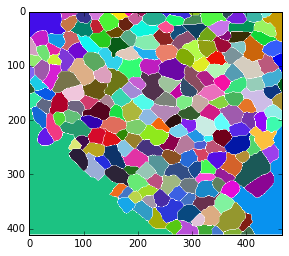

In [23]:
plt.imshow(segmented)

In [35]:
edges = []
for s in delaunay.simplices:
    edges.append([(s[0], s[1]),
                  (s[0], s[2]),
                  (s[1], s[2])])

In [25]:
types.shape, segmented.shape

((412, 467, 3), (412, 467, 3))

In [26]:
np.unique(types)

array([  0, 255], dtype=uint8)

In [27]:
types.shape

(412, 467, 3)

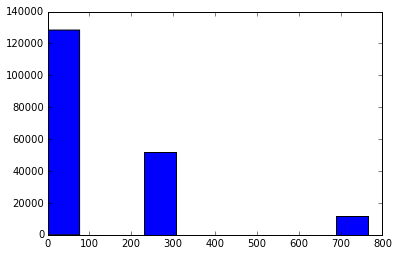

In [33]:
fig, ax =  plt.subplots()

h = ax.hist(types.sum(axis=2).ravel())

In [34]:
255*3

765

In [ ]:
segemented